In [18]:
import yfinance as yf
import pandas as pd
import numpy as np

In [19]:
from datetime import datetime, timedelta
ticker = "URTH"  # iShares MSCI World ETF
current_date = datetime.today()
start_date = pd.to_datetime('2013-12-22')
msci_world_data = yf.download(ticker, start=start_date, end=current_date)
df = msci_world_data[['Close']].copy()
df['mean_7rollw'] = df['Close'].rolling(window=7).mean()
df['daily_yeld'] = df['Close']/df['Close'].shift(1) -1
df = df.dropna()

[*********************100%%**********************]  1 of 1 completed


In [20]:
#bck = df

In [21]:
df = bck

#### Time range params

In [22]:
start_date = pd.to_datetime('2013-12-22')
end_date = pd.to_datetime('2024-09-04')
df = df[(df.index > start_date) & (df.index < end_date)].copy()

#### Investing strategies

In [23]:
df['Buy_month_first'] = 0.0
monthly_budget_mf = 1000

buy on the first open market day of the month using the entire monthly budget

In [24]:
df['Buy_low'] = 0.0
monthly_budget_bl = monthly_budget_mf
buy_low_times_x_month = 10
wait_after_buy = 1 #days
margin = 0.97

buy using a portion of the budget when the price is below past 7 days mean price, waiting N days to buy again.
In case of not fully invested budget (no price decreases), use the remaining budget in the next month

#### Simulation

In [25]:
iter_month = df.index[0].month
days_without_buying = wait_after_buy
buy_low_portion = monthly_budget_bl / buy_low_times_x_month
month_buy_count = 0
uninvested = 0

for date, col in df.iterrows():
    price = col['Close']
    mean_7rollw = col['mean_7rollw']

    #Buy_low
    if price < mean_7rollw*margin and days_without_buying >= wait_after_buy:
        df.loc[date, 'Buy_low'] = buy_low_portion
        monthly_budget_bl -= buy_low_portion
        days_without_buying = 0
        month_buy_count += 1
    else:
        days_without_buying += 1

    if date.month != iter_month: #new month
        monthly_budget_bl += monthly_budget_mf 
        buy_low_portion = monthly_budget_bl / buy_low_times_x_month
        month_buy_count = 0
        iter_month = date.month

        #Buy_month_first logic
        df.loc[date, 'Buy_month_first'] = monthly_budget_mf

Delta between total investments of the strategies

In [26]:
total_invested_mf = df['Buy_month_first'].sum()
total_invested_bl = df['Buy_low'].sum()
uninvested_bl =  total_invested_mf - total_invested_bl
uninvested_bl

32140.480663842434

Results

In [27]:
#update values to today price in new cols
current_price = df['Close'].iloc[-1]
df['Buy_month_first_today_val'] = df['Buy_month_first'] / df['Close'] * current_price
df['Buy_low_today_val'] = df['Buy_low'] / df['Close'] * current_price

In [28]:
final_value_mf = df['Buy_month_first_today_val'].sum()
final_value_bl = df['Buy_low_today_val'].sum() + uninvested_bl

In [29]:
yeld_mf = final_value_mf/total_invested_mf - 1
yeld_mf*100

65.24036810488305

In [30]:
yeld_bl = final_value_bl/total_invested_bl - 1
yeld_bl*100

104.98686861085731

In [31]:
(final_value_bl - final_value_mf + uninvested_bl)/final_value_mf*100

8.100054407996597

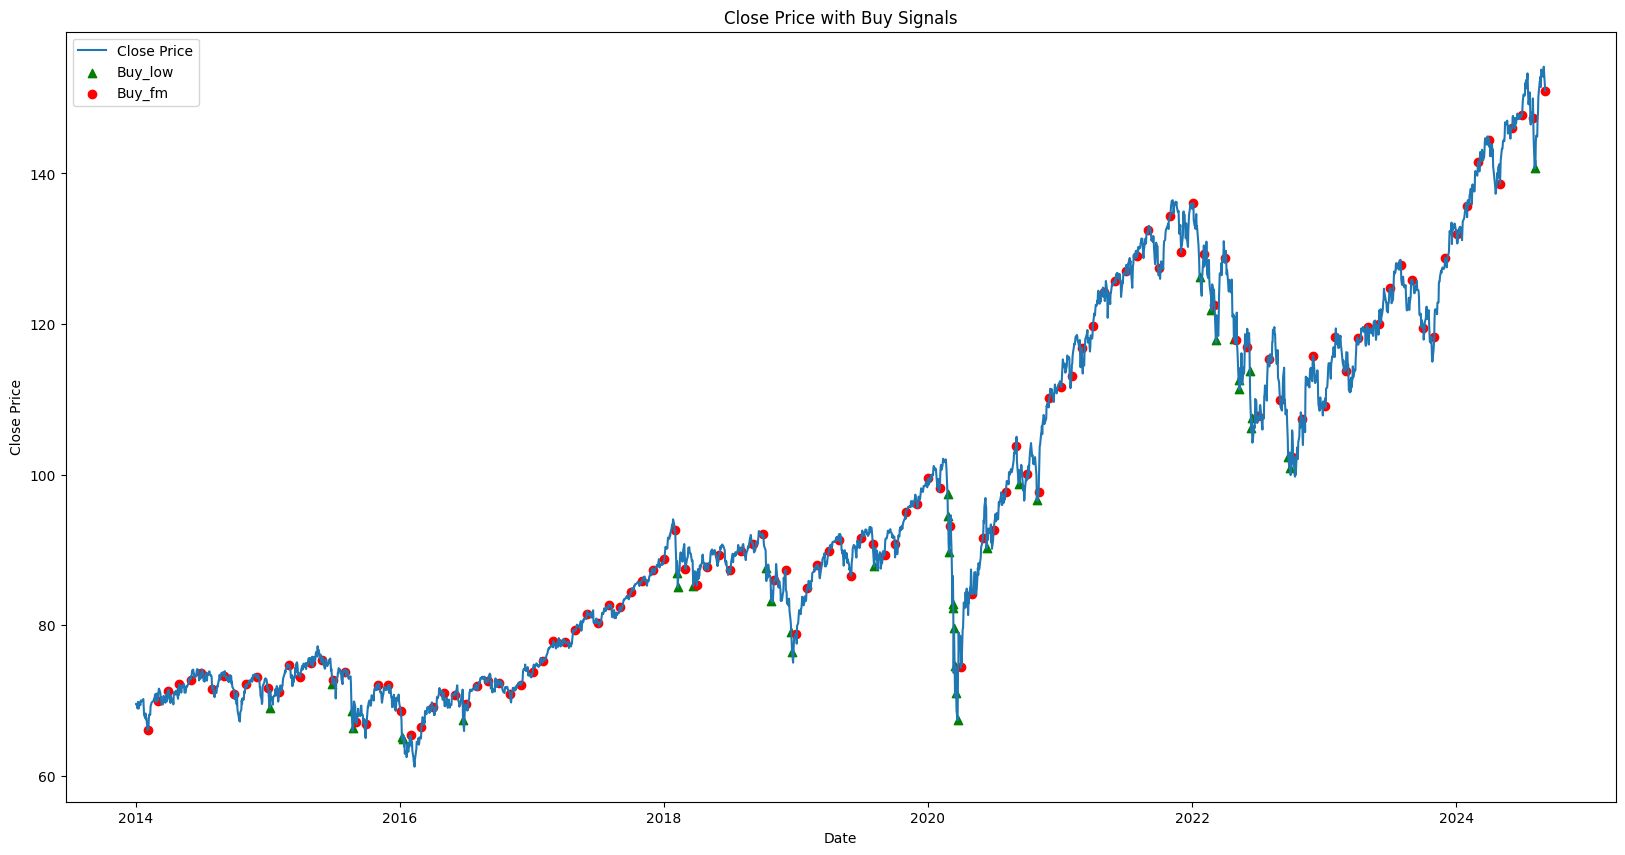

In [32]:
import matplotlib.pyplot as plt

# Plot the Close price
plt.figure(figsize=(20,10))
plt.plot(df.index, df['Close'], label='Close Price')

# Highlight buy spots for buy low strategy
plt.scatter(df.index[df['Buy_low'] > 0], df['Close'][df['Buy_low'] > 0], color='green', label='Buy_low', marker='^', alpha=1)

# Highlight buy spots for the "first of the month" strategy
plt.scatter(df.index[df['Buy_month_first'] > 0], df['Close'][df['Buy_month_first'] > 0], color='red', label='Buy_fm', marker='o', alpha=1)

# Adding labels and legend
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price with Buy Signals')
plt.legend()

# Show the plot
plt.show()


In [33]:
#df['Buy_month_first_cumyeld'] = df['daily_yeld'] * df['Buy_month_first'].cumsum().shift(1)
#df['Buy_low_cumsum_cumyeld'] = df['daily_yeld'] * df['Buy_low'].cumsum().shift(1)